#Машинное обучение, Лабораторная работа №5

**Преподаватель**: Свинцов М. В.

**Выполнили**: Румянцев А. А. 368731, Чебаненко Д. А. 367609, R3341, МашОб 31 1.

**Цель работы**: построить модели классификации на основе ансамблевых алгоритмов: бэггинг и градиентный бустинг, содержащие в качестве базовых алгоритмов решающие деревья.

**Инструменты**: бэггинг решающих деревьев (случайный лес, RandomForestClassifier), градиентный бустинг над решающими деревьями (GradientBoostingClassifier).



##Содержание

Построить модели классификации для соответствующего датасета. Для этого:
1. Воспользоваться результатами Лабораторной работы №1 по препроцессингу данных.
2. Разбить данные на обучающую и тестовую выборки (например, в соотношении 80/20).
3. Построить модели классификаторов при различных наборов гиперпараметров (выбрать самостоятельно).
4. Обучить модели на обучающих частях выборки.
5. Провести сравнительную оценку качества моделей на основе тестовой выборки. Критерии сравнения определяются самостоятельно.

#Подготовка

##Импорт необходимых библиотек

Будем работать с таблицами, вычислениями, моделями и графиками.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

##Подключение диска

Подключим диск, чтобы иметь доступ к сохраненным в первой лабораторной датасетам.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Считывание датасета

В этой лабораторной работаем только с классификацией. Считаем соответствующий датасет, обработанный в первой лабораторной работе. Выведем таблицу

In [ ]:
df_classif=pd.read_csv('drive/My Drive/new_heart.csv')
df_classif

,oldpeak,age_heart_rate_reserve,physical_fitness,sex,cp,exang,slope,ca,thal,target
0,1.087338,-0.606321,0.298233,1,3,0,0,0,1,1
1,2.122573,2.301531,-1.006925,1,2,0,0,0,2,1
2,0.310912,1.566541,-0.715457,0,1,0,2,0,2,1
3,-0.206705,0.374341,-1.108028,1,1,0,2,0,2,1
4,-0.379244,-0.002645,-0.809770,0,0,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...
298,-0.724323,-0.833661,1.122947,0,0,1,1,0,3,0
299,0.138373,0.066187,-0.342777,1,3,0,1,0,3,0
300,2.036303,-0.990186,0.560774,1,0,0,1,2,3,0
301,0.138373,-1.022528,1.085560,1,0,1,1,1,3,0


##Разделение на обучающую и тестовую выборки

Разделим данные на обучающую и тестовую выборки в соотношении 80 к 20. Выведем размерности обучающей выборки и исходной таблицы

In [ ]:
X = df_classif.drop('target', axis=1)
y = df_classif['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, df_classif.shape

((242, 9), (303, 10))

#Случайный лес

Рассмотрим случайный лес.

##Гиперпараметры и обучение

Зададим такой набор гиперпараметров:
1. `n_estimators` -- количество деревьев в случайном лесу
2. `max_depth` -- максимальная глубина каждого дерева (ограничивает количество раз разделения данных)
3. `min_samples_leaf` -- минимальное кол-во примеров в каждом листе дерева (если меньше, то дерево остановится)
4. `min_samples_split` -- минимальное количество выборок для разделения узла (если меньше, то узел станет листом)
5. `max_features` -- максимальное кол-во признаков, которые будут использоваться при каждом разделении дерева

Отличие `min_samples_split` от `min_samples_leaf`:
например, если `min_samples_split=5` и во внутреннем узле имеется 7 выборок, то разделение разрешено. Но предположим, что в результате разделения получилось два листа: один с 1 образцом, а другой с 6 образцами. Если `min_samples_leaf=2`, то разделение не будет разрешено (даже если внутренний узел имеет 7 выборок), поскольку в одном из полученных листьев будет меньше минимального количества выборок, которое должно быть в листовом узле. `min_samples_leaf` гарантирует минимальное количество выборок в каждом листе, независимо от значения `min_samples_split`.

Создадим словарь из этих гиперпараметров, присвоив каждому набор некоторых значений. Воспользуемся `GridSearchCV`, который имплементирует кросс-валидацию, чтобы перебрать все возможные комбинации гиперпараметров и выбрать наилучшую модель в соответствии с заданным способом оценки. Зададим `cv=4` -- данные разделятся на 3 обучающих выборки и 1 тестовую. Оценивать будем по точности -- итоговая оценка считается как среднее по результатам тестов всех фолдов. Обучим множество моделей

In [ ]:
par_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=100)
rf_grid = GridSearchCV(rf, par_rf, cv=4, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

##Результат с наивысшей оценкой

Выведем параметры модели с лучшим результатом согласно нашему способу оценки и среднее точности по всем фолдам

In [ ]:
print(f"Highest score {type(rf).__name__} parameters: {rf_grid.best_params_}")
print(f"Highest accuracy on all folds: {rf_grid.best_score_:.2f}")

Highest score RandomForestClassifier parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Highest accuracy on all folds: 0.83


Результат от запуска к запуску меняется. Высокая точность на фолдах не гарантирует высокой точности на тестовой выборке, аналогично с низкой точностью.

##Сравнение моделей

Сравнивать будем три модели из множества `grid`: с наивысшей, медианной и наименьшей оценками. Описание методов:
1. `get_highest_score_params` -- возвращает кортеж, где лучшей оценке соответствует лучший набор параметров
2. `get_median_score_params` -- считает медиану всех оценок и ищет параметры модели, оценка которых наиболее близка к медиане. Возвращает кортеж с медианной оценкой и соответствующими параметрами
3. `get_lowest_score_params` -- находит параметры модели с минимальной оценкой качества. Возвращает кортеж с наименьшей оценкой и соответствующими параметрами

In [ ]:
def get_highest_score_params(grid_search):
  return (grid_search.best_score_, grid_search.best_params_)


def get_median_score_params(grid_search, scoring='mean_test_score'):
    scores = grid_search.cv_results_[scoring]
    median_score = np.median(scores)

    closest_index = np.abs(scores - median_score).argmin()
    median_score_params = grid_search.cv_results_['params'][closest_index]
    median_score = scores[closest_index]
    return (median_score, median_score_params)


def get_lowest_score_params(grid_search, scoring='mean_test_score'):
  lowest_score_index = grid_search.cv_results_[scoring].argmin()
  lowest_score_params = grid_search.cv_results_['params'][lowest_score_index]
  lowest_score = grid_search.cv_results_[scoring][lowest_score_index]
  return (lowest_score, lowest_score_params)

Воспользуемся методами, чтобы отобрать 3 набора параметров для сравнения моделей. Выведем оценку и гиперпараметры для каждой пары "точность-параметры"

In [ ]:
highest_rf_score_params = get_highest_score_params(rf_grid)
median_rf_score_params = get_median_score_params(rf_grid)
lowest_rf_score_params = get_lowest_score_params(rf_grid)
sorted_rf_params_for_comparison = [highest_rf_score_params[1],
                                   median_rf_score_params[1],
                                   lowest_rf_score_params[1]]
print(f"Highest score: {highest_rf_score_params[0]:.2f}")
print(f"Median score: {median_rf_score_params[0]:.2f}")
print(f"Lowest score: {lowest_rf_score_params[0]:.2f}")
sorted_rf_params_for_comparison

Highest score: 0.83
Median score: 0.80
Lowest score: 0.77


[{'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'n_estimators': 10},
 {'max_depth': 5,
  'max_features': None,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 10},
 {'max_depth': 10,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100}]

Точность достаточно стабильна для всех моделей, так как разница между максимумом и минимумом небольшая и медиана посередине.

Напишем методы для удобной работы с несколькими моделями. Описание методов:
1. `get_trained_classif_models` -- обучает переданное количество моделей классификации на обучающем наборе данных. Возвращает список обученных моделей
2. `get_preds_classif_models` -- использует переданные в метод модели классификации для предсказания меток на тестовом наборе данных. Возвращает список предсказаний
3. `get_evals_classif_models` -- для предсказания каждой модели классификации считает `classification_report`, сравнивая с истинными метками. Возвращает список отчетов

In [ ]:
def get_trained_classif_models(classif_models, X_train, y_train):
  trained_models = []
  for model in classif_models:
    trained_model = model.fit(X_train, y_train)
    trained_models.append(trained_model)
  return trained_models


def get_preds_classif_models(classif_models, X_test):
  y_preds = []
  for model in classif_models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)
  return y_preds


def get_evals_classif_models(y_preds, y_test):
    reports = []
    for y_pred in y_preds:
        report = classification_report(y_test, y_pred)
        reports.append(report)
    return reports

Берем из списка кортежей с тремя парами "оценка-параметры" каждую и создаем модели по параметрам. Модели сохраним в список на обучение. Обучаем, используя написанный нами метод `get_trained_classif_models`. Выведем обученные модели со своими гиперпараметрами

In [ ]:
rs = 100
highest_score_rf_model = RandomForestClassifier(
    **sorted_rf_params_for_comparison[0], random_state=rs
)
median_score_rf_model = RandomForestClassifier(
    **sorted_rf_params_for_comparison[1], random_state=rs
)
lowest_score_rf_model = RandomForestClassifier(
    **sorted_rf_params_for_comparison[2], random_state=rs
)

rf_models_to_train = [highest_score_rf_model, median_score_rf_model,
                      lowest_score_rf_model]
trained_rf_models = get_trained_classif_models(rf_models_to_train, X_train,
                                               y_train)
trained_rf_models

[RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                        n_estimators=10, random_state=100),
 RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=5,
                        n_estimators=10, random_state=100),
 RandomForestClassifier(max_depth=10, max_features=None, random_state=100)]

Используем модели для предсказания меток. Выведем результаты

In [ ]:
rf_y_preds = get_preds_classif_models(trained_rf_models, X_test)
rf_y_preds

[array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1])]

Сравним модели с помощью `classification_report`. Воспользуемся нашим методом `get_evals_classif_models`, после чего выведем результат для каждой модели

In [ ]:
rf_reports = get_evals_classif_models(rf_y_preds, y_test)
titles = ["Highest score model", "Median score model", "Lowest score model"]
print(f"{type(rf).__name__} models comparison on test data:")
print("-" * 53)
for i in range(len(rf_reports)):
    print(f"{titles[i]}: {sorted_rf_params_for_comparison[i]}:")
    print("-" * 53)
    print(rf_reports[i])
    print("-" * 53)

RandomForestClassifier models comparison on test data:
-----------------------------------------------------
Highest score model: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.89      0.89      0.89        35

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

-----------------------------------------------------
Median score model: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        26
           1       0.86      0.89  

Обозначим модель 1 -- модель с наивысшей точностью на обучающей выборке, модель 2 -- с медианной точностью на обучающей выборке, модель 3 -- с наименьшей точностью на обучающей выборке.

Как видим, модель 3 имеет на тестовой выборке бóльшую точность, чем модели 1 и 2. Это может быть результатом случайности. Возможно модель 1 будет более стабильной, так как показала выше точность на бóльшем количестве данных при обучении.

Тем не менее, исследуем полученные результаты.

Модель 3 при бóльшем количестве деревьев, их бóльшей глубине и, меньшем нижнем ограничении на кол-во примеров в каждом листе дерева, показала на 4% лучше результат по сравнению с моделью 2. У этой модели больше "пространства" по сравнению с другими. Возможно остальные модели слегка недообучились из-за ограничений (а при `GridSearch` из-за разбиения обучающей выборки на `cv=a-1` выборок их точность была выше). С другой стороны, низкая точность этой модели на обучающей выборке может говорить как-раз о ее переобучении. Способность модели обнаруживать классы (`recall`) и отличать их друг от друга (`precision`) немного улучшилась по сравнению с моделью 2. Так как `f1`-мера является средним гармоническим точности и полноты, то она тоже увеличилась для каждого класса. Далее будем называть эти результаты метриками.

Модель 1 имеет более хорошие метрики, чем модель 2. Наблюдаем баланс между `precision` и `recall`. Возможно это потому, что нижнее ограничение на кол-во примеров в каждом листе дерева так же как и в модели 3 меньше. При этом модель использует лишь квадратный корень из общего числа признаков для поиска оптимального разбиения на каждом узле. Скорее всего это один из тех параметров, благодаря которому точность этой модели на обучающей выборке наибольшая.

Для визуализации построим графики ROC-кривых (рабочая характеристика приёмника) и precision-recall-кривых (точность-полнота). Также на каждом графике выведем посчитанные AUC (площадь под кривой). Описание методов:
1. `roc_curve_plot` -- для каждой модели классификации считает ROC-кривую по предсказанным вероятностям принадлежности к положительному классу (1) и тестовым меткам. Считает AUC по ложноположительному (FPR) и истинноположительному (TPR) показателям. Строит кривую с подписанным AUC и возвращает `plot`. Используется для визуализации способности модели различать положительный и отрицательный классы при различных порогах вероятностей (порог классификации -- значение, выше которого модель относит объект к положительному классу), использованных для вычисления FPR и TPR.
2. `precision_recall_plot` -- для каждой модели классификации считает precision-recall-кривую по предсказанным вероятностям принадлежности к положительному классу (1) и тестовым меткам. Строит кривую с подписанным AUC и возвращает `plot`. Используется для визуализации измененения точности и полноты при изменении порога классификации.

In [ ]:
def roc_curve_plot(models, X_test, y_test, titles):
  plt.figure(figsize=(12, 4))
  i = 0
  for model in models:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, len(models), i + 1)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(titles[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='lower right')
    plt.grid()

    i += 1
  plt.suptitle('Receiver operating characteristic curve')
  plt.tight_layout()
  return plt


def precision_recall_plot(models, X_test, y_test, titles):
  plt.figure(figsize=(12, 4))
  i = 0
  for model in models:
    precision, recall, _ = precision_recall_curve(y_test,
                                                  model\
                                                  .predict_proba(X_test)[:, 1])

    plt.subplot(1, len(models), i + 1)
    plt.plot(recall, precision, label=f"AUC = {auc(recall, precision):.2f}")
    plt.title(titles[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid()

    i += 1

  plt.suptitle('Precision-recall curve')
  plt.tight_layout()
  return plt

Построим график ROC-кривой для каждой модели классификации, используя наш метод `roc_curve_plot`. Покажем рисунок

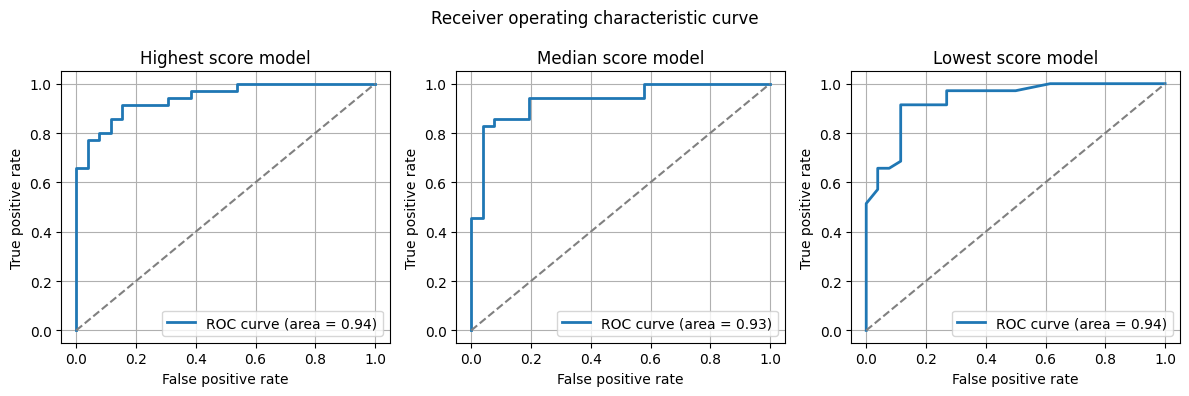

In [ ]:
titles = ["Highest score model", "Median score model", "Lowest score model"]
roc_curve_plot(trained_rf_models, X_test, y_test, titles)
plt.show()

Чем выше ломаная от прямой, тем лучше у модели различительная способность между положительными и отрицательными классами. Похоже, что лучше всего результат у модели 1, однако все модели справились примерно одинаково хорошо, так как площади под графиками близки к 1.

Построим график precision-recall-кривой для каждой модели классификации, используя наш метод `precision_recall_plot`. Покажем рисунок

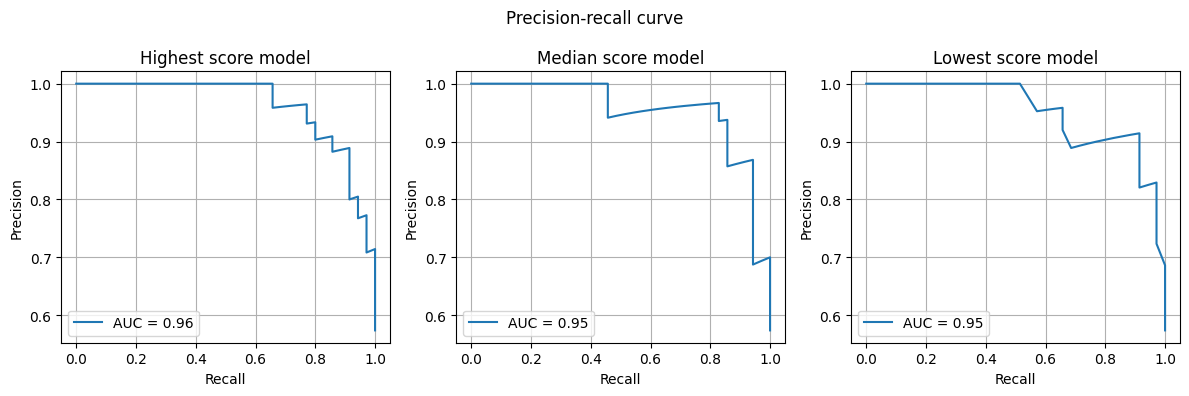

In [ ]:
titles = ["Highest score model", "Median score model", "Lowest score model"]
precision_recall_plot(trained_rf_models, X_test, y_test, titles)
plt.show()

Чем выше значение `precision` при фиксированном `recall`, тем точнее модель предсказывает положительный класс. График модели с плохими параметрами выглядел бы как горизонтальная прямая с точностью, пропорциональной количеству положительных примеров в наборе данных (если данные сбалансированы, то точность 0.5). Лучше всего результат у модели 1, так как при увеличении полноты до 1 ее точность ухудшается позже всех остальных моделей. Раньше всех у модели 2, однако, в отличие от модели 3, у нее дольше сохраняется хорошая точность при увеличении `recall`. AUC больше всего у модели 1, но разница минимальна.

Из трех моделей мы бы предпочли использовать первую, так как она показала лучший результат на обучающей выборке и хороший результат на тестовой. Третья модель, вероятно, может быть склонна к переобучению, и, делать некорректные предсказания на другой тестовой выборке.

#Градиентный бустинг

Рассмотрим градиентный бустинг.

##Гиперпараметры и обучение

Зададим такой набор гиперпараметров:
1. `n_estimators` -- количество деревьев в ансамбле
2. `learning_rate` -- скорость обучения (контролирует вклад каждого дерева в итоговую модель)
3. `max_depth` -- максимальная глубина деревьев
4. `min_samples_split` -- минимальное количество объектов, необходимое для разделения узла
5. `subsample` -- доля выборки, используемая для обучения каждого дерева

Проделаем аналогичные действия с `GridSearchCV` для обучения множества моделей

In [ ]:
par_gb = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.001, 0.1, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=100)
gb_grid = GridSearchCV(gb, par_gb, cv=4, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 100],
                         'max_depth': [5, 10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

##Результат с наивысшей оценкой

Выведем параметры модели с лучшим результатом согласно нашему способу оценки и среднее точности по всем фолдам

In [ ]:
print(f"Highest score {type(gb).__name__} parameters: {gb_grid.best_params_}")
print(f"Highest accuracy on all folds: {gb_grid.best_score_:.2f}")

Highest score GradientBoostingClassifier parameters: {'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.6}
Highest accuracy on all folds: 0.82


Вывод аналогичен пункту со случайным лесом.

##Сравнение моделей

Аналогично сравним три модели. Выведем оценку и гиперпараметры для каждой пары "точность-параметры"

In [ ]:
highest_gb_score_params = get_highest_score_params(gb_grid)
median_gb_score_params = get_median_score_params(gb_grid)
lowest_gb_score_params = get_lowest_score_params(gb_grid)
sorted_gb_params_for_comparison = [highest_gb_score_params[1],
                                   median_gb_score_params[1],
                                   lowest_gb_score_params[1]]
print(f"Highest score: {highest_gb_score_params[0]:.2f}")
print(f"Median score: {median_gb_score_params[0]:.2f}")
print(f"Lowest score: {lowest_gb_score_params[0]:.2f}")
sorted_gb_params_for_comparison

Highest score: 0.82
Median score: 0.62
Lowest score: 0.46


[{'learning_rate': 0.1,
  'max_depth': 20,
  'min_samples_split': 5,
  'n_estimators': 50,
  'subsample': 0.6},
 {'learning_rate': 100,
  'max_depth': 20,
  'min_samples_split': 10,
  'n_estimators': 10,
  'subsample': 1.0},
 {'learning_rate': 100,
  'max_depth': 5,
  'min_samples_split': 10,
  'n_estimators': 10,
  'subsample': 1.0}]

Точность между минимумом и максимумом отличается почти в 2 раза. В этом случае точность нестабильна, медиана немного смещена.

Аналогично создадим модели для сравнения. Выведем их со своими гиперпараметрами

In [ ]:
rs = 100
highest_score_gb_model = GradientBoostingClassifier(
    **sorted_gb_params_for_comparison[0], random_state=rs
)
median_score_gb_model = GradientBoostingClassifier(
    **sorted_gb_params_for_comparison[1], random_state=rs
)
lowest_score_gb_model = GradientBoostingClassifier(
    **sorted_gb_params_for_comparison[2], random_state=rs
)

gb_models_to_train = [highest_score_gb_model, median_score_gb_model,
                      lowest_score_gb_model]
trained_gb_models = get_trained_classif_models(gb_models_to_train, X_train,
                                               y_train)
trained_gb_models

[GradientBoostingClassifier(max_depth=20, min_samples_split=5, n_estimators=50,
                            random_state=100, subsample=0.6),
 GradientBoostingClassifier(learning_rate=100, max_depth=20,
                            min_samples_split=10, n_estimators=10,
                            random_state=100),
 GradientBoostingClassifier(learning_rate=100, max_depth=5, min_samples_split=10,
                            n_estimators=10, random_state=100)]

Используем модели для предсказания меток. Выведем результаты

In [ ]:
gb_y_preds = get_preds_classif_models(trained_gb_models, X_test)
gb_y_preds

[array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]),
 array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]),
 array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0])]

Сравним модели по `classification_report`. Выведем результат `get_evals_classif_models`

In [ ]:
gb_reports = get_evals_classif_models(gb_y_preds, y_test)
titles = ["Highest score model", "Median score model", "Lowest score model"]
print(f"{type(gb).__name__} models comparison on test data:")
print("-" * 53)
for i in range(len(gb_reports)):
    print(f"{titles[i]}: {sorted_gb_params_for_comparison[i]}:")
    print("-" * 53)
    print(gb_reports[i])
    print("-" * 53)

GradientBoostingClassifier models comparison on test data:
-----------------------------------------------------
Highest score model: {'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.6}:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.91      0.91      0.91        35

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

-----------------------------------------------------
Median score model: {'learning_rate': 100, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 10, 'subsample': 1.0}:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.31      0.15      0.21        26
           1       0.54      0.74      0.

Обозначим модель 1 -- модель с наивысшей точностью на обучающей выборке, модель 2 -- с медианной точностью на обучающей выборке, модель 3 -- с наименьшей точностью на обучающей выборке.

Единственный хороший и лучший результат показала модель 1. Стоит заметить, что для каждого класса `precision` и `recall` сбалансированы -- модель одинаково хорошо классифицирует положительные и отрицательные примеры. Модель 2 же неплохо распознает положительные классы, но с трудом классифицирует отрицательные (см. `recall`). Несмотря на неплохой `recall` для 1, точность для этого класса оказывается низкой. Модель в целом плохо обобщает данные. Модель 3 отличается от модели 2 только параметром максимальной глубины деревьев -- она меньше, при этом точность хоть и стала выше, но не намного, и, модель 3 стала хуже распознавать положительные классы. Однако стала лучше классифицировать отрицательные классы. Низкая точность может быть связана с высоким значением `learning_rate` -- у первой модели оно намного меньше. При этом у первой модели так же как и у второй максимальная глубина деревьев равна 20, однако больше деревьев, и, узлы потенциально делятся чаще. Чтобы с такими параметрами первая модель не переобучилась, ей нужно уменьшить долю обучающей выборки на каждое дерево (как раз `subsample=0.6` вместо 1.0) и задать низкое значение `learning_rate` (более аккуратной контроль весов, как раз 0.1 вместо 100). Поэтому результат первой модели настолько точный.

Построим график ROC-кривой для каждой модели. Покажем рисунок

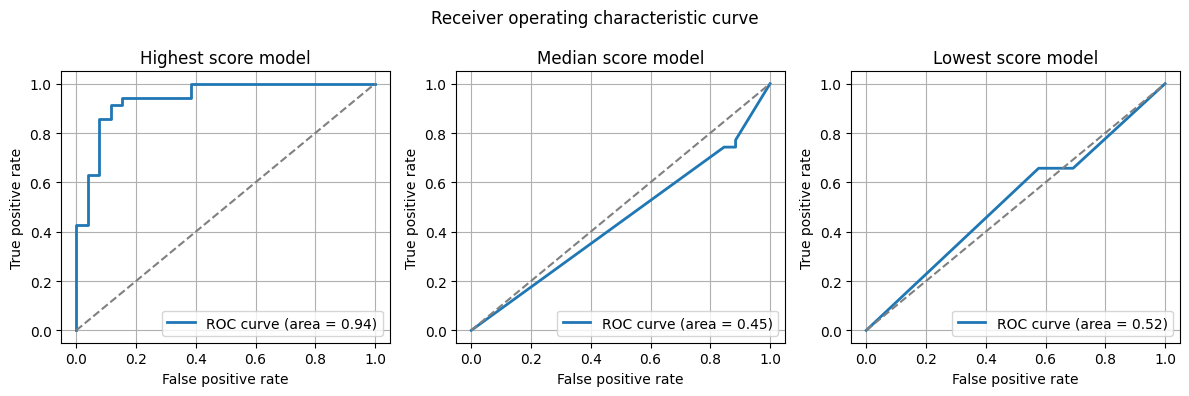

In [ ]:
titles = ["Highest score model", "Median score model", "Lowest score model"]
roc_curve_plot(trained_gb_models, X_test, y_test, titles)
plt.show()

Единственный хороший результат у модели 1 -- график находится высоко относительно прямой, площадь под графиком близка к 1. Остальные модели показывают результат примерно на уровне случайного предсказания, то есть не обладают значительной различительной способностью. В случае модели 2 случайные предсказания оказываются даже лучше.

Построим график precision-recall-кривой для каждой модели. Покажем рисунок

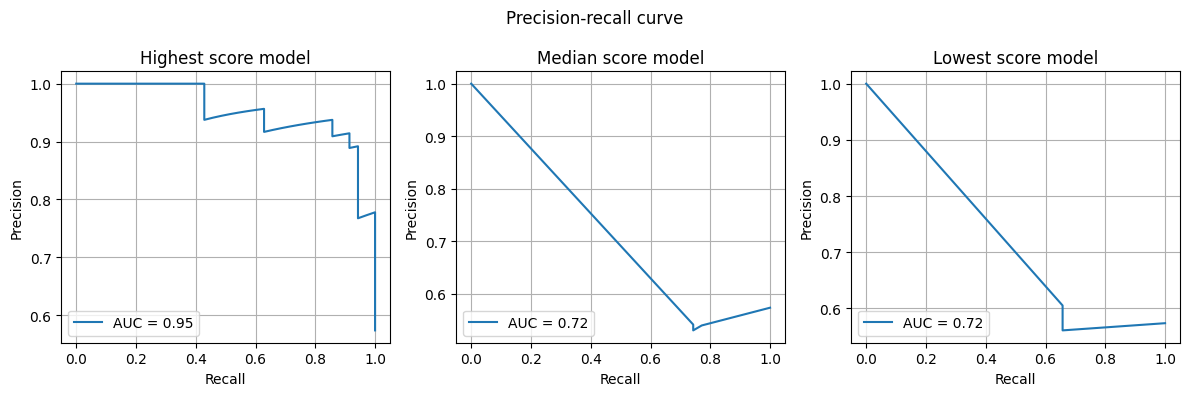

In [ ]:
titles = ["Highest score model", "Median score model", "Lowest score model"]
precision_recall_plot(trained_gb_models, X_test, y_test, titles)
plt.show()

Ожидаемо хороший и лучший результат только у модели 1. Точность падает рано при увеличенни `recall`, но все еще остается на высоком уровне. AUC очень высокий. Остальные модели плохо справляются с балансом точности и полноты и имеют более низкий AUC, то есть хуже различают классы. Модель 2 хоть и не имеет резкого скачка вниз на больших recall, как у модели 3, однако стабильно хуже по точности, лишь только в конце возрастая до примерно уровня точности модели 3.

Из трех моделей мы очевидно выбрали первую -- другие две с ней не соревнуются. Она имеет лучший результат на обучающей и тестовой выборках.